In [1]:
def trading_strategy(data, strategy_type):
    total_profit = 0
    total_loss = 0
    wins = 0
    losses = 0
    trades = 0
    bought = False
    max_profit = 0
    max_loss = 0
    max_holding_period = 0
    total_holding_period = 0
    entry_price = 0
    entry_price_index = 0  # 매수 시점을 기록하기 위한 변수
    data['Adj Open'] = data['Open'] * data['Adj Close'] / data['Close']  # 수정 시가
    
    # 전략에 따른 처리
    for i in range(1, len(data)):
        if strategy_type == 1:  # 첫 신호 매매
            if not bought and data['Pre'].iloc[i] == 1 and data['Pre'].iloc[i-1] == 0:  # 매수 신호
                entry_price_index = i  # 매수 시점 기록
                bought = True
            elif bought and data['Pre'].iloc[i] == 0 and data['Pre'].iloc[i-1] == 1:  # 매도 신호
                result = data['Adj Open'].iloc[i] - data['Adj Open'].iloc[i-1]  # 전날 시가와의 차이
                holding_period = i - entry_price_index  # 보유 기간 계산
                total_holding_period += holding_period  # 총 보유 기간
                max_holding_period = max(max_holding_period, holding_period)  # 최대 보유 기간 갱신
                if result > 0:  # 수익
                    total_profit += result
                    wins += 1
                    max_profit = max(max_profit, result)
                elif result < 0:  # 손실
                    total_loss += abs(result)
                    losses += 1
                    max_loss = max(max_loss, abs(result))
                else:  # 수익 = 0(전날 시가와 현재 시가가 같을 때)
                    pass
                trades += 1
                bought = False
            elif bought:  # hold
                result = data['Adj Open'].iloc[i] - data['Adj Open'].iloc[i-1]
                if result > 0:  # 수익
                    total_profit += result
                    wins += 1
                    max_profit = max(max_profit, result)
                elif result < 0:  # 손실
                    total_loss += abs(result)
                    losses += 1
                    max_loss = max(max_loss, abs(result))
                else:  # 수익 = 0(전날 시가와 현재 시가가 같을 때)
                    pass 
            else:  # 매도 ~ 매수
                pass  
            
    # 마지막에 주식을 보유하고 있다면 종가로 청산
    if bought:
        result = data['Adj Close'].iloc[-1] - data['Adj Open'].iloc[-1]
        holding_period = len(data) - entry_price_index + 1  # 마지막까지 보유했을 때의 기간 계산
        total_holding_period += holding_period
        max_holding_period = max(max_holding_period, holding_period)  # 최대 보유 기간 갱신
        if result > 0:
            total_profit += result
            wins += 1
            max_profit = max(max_profit, result)
        elif result < 0:  # 손실
                    total_loss += abs(result)
                    losses += 1
                    max_loss = max(max_loss, abs(result))
        else:  # 수익 = 0(전날 시가와 현재 시가가 같을 때)
            pass
        trades += 1


    # 성과 지표 계산
    average_profit_per_winning_trade = total_profit / wins if wins > 0 else float('inf')
    average_loss_per_losing_trade = total_loss / losses if losses > 0 else float('inf')
    payoff_ratio = average_profit_per_winning_trade / average_loss_per_losing_trade if average_loss_per_losing_trade != 0 else float('inf')
    profit_factor = total_profit / total_loss if total_loss != 0 else float('inf')
    win_rate = (wins / trades) * 100 if trades > 0 else float('inf')

    # 지표 반환
    return {
        "Total Profit": total_profit,  # 누적 이익
        "Total Loss": total_loss,  # 누적 손실
        "Payoff Ratio": payoff_ratio,  # 지급 비율
        "Profit Factor": profit_factor,  # 이익 계수
        "Win Rate": win_rate,  # 승률
        "Total Trades": trades,  # 총 거래 수
        "Max Holding Period": max_holding_period,  # 최대 홀딩 기간
        "Max Profit": max_profit,  # 최대 이익 
        "Max Loss": max_loss,  # 최대손실
    }                                 

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import talib as ta
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (Windows의 경우 기본적으로 'Malgun Gothic'을 사용)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 종목 리스트 정의
tickers = [
    '005930.KS', '005935.KS', '000660.KS', '005387.KS', '005385.KS', '005380.KS', '005389.KS', '068270.KS',
    '000270.KS', '105560.KS', '055550.KS', '035420.KS', '005490.KS', '02826K.KS', '028260.KS', '051910.KS',
    '051915.KS', '006400.KS', '006405.KS', '012330.KS', '086790.KS', '035720.KS', '066575.KS', '066570.KS',
    '032830.KS', '012450.KS', '000815.KS', '000810.KS', '009540.KS', '011200.KS', '003555.KS', '003550.KS',
    '015760.KS', '017670.KS', '034020.KS', '018260.KS', '033780.KS', '024110.KS', '010130.KS', '009150.KS'
]

# 전략별 결과를 저장할 리스트 초기화
results_test_all = {i: [] for i in range(1, 7)}  # 전략 1 ~ 6

In [3]:
def trading_strategy(data, strategy_type):
    total_profit = 0
    total_loss = 0
    wins = 0
    losses = 0
    trades = 0
    bought = False
    max_profit = 0
    max_loss = 0
    max_holding_period = 0
    total_holding_period = 0
    entry_price = 0
    entry_price_index = 0  # 매수 시점을 기록하기 위한 변수
    data['Adj Open'] = data['Open'] * data['Adj Close'] / data['Close']  # 수정 시가

    # 전략에 따른 처리           
    for i in range(1, len(data)):
        if strategy_type == 1:  # 첫 신호 매매
            if not bought and data['Pre'].iloc[i] == 1 and data['Pre'].iloc[i-1] == 0:  # 매수 신호
                entry_price_index = i  # 매수 시점 기록
                bought = True
            elif bought and data['Pre'].iloc[i] == 0 and data['Pre'].iloc[i-1] == 1:  # 매도 신호
                result = data['Adj Open'].iloc[i] - data['Adj Open'].iloc[i-1]  # 전날 시가와의 차이
                holding_period = i - entry_price_index  # 보유 기간 계산
                total_holding_period += holding_period  # 총 보유 기간
                max_holding_period = max(max_holding_period, holding_period)  # 최대 보유 기간 갱신
                if result > 0:  # 수익
                    total_profit += result
                    wins += 1
                    max_profit = max(max_profit, result)
                elif result < 0:  # 손실
                    total_loss += abs(result)
                    losses += 1
                    max_loss = max(max_loss, abs(result))
                else:  # 수익 = 0(전날 시가와 현재 시가가 같을 때)
                    pass
                trades += 1
                bought = False
            elif bought:  # hold
                result = data['Adj Open'].iloc[i] - data['Adj Open'].iloc[i-1]
                if result > 0:  # 수익
                    total_profit += result
                    wins += 1
                    max_profit = max(max_profit, result)
                elif result < 0:  # 손실
                    total_loss += abs(result)
                    losses += 1
                    max_loss = max(max_loss, abs(result))
                else:  # 수익 = 0(전날 시가와 현재 시가가 같을 때)
                    pass 
            else:  # 매도 ~ 매수
                pass 

        elif strategy_type == 2:  # 두 번 연속 신호 매매
            if i >= 2 and not bought and data['Pre'].iloc[i] == 1 and data['Pre'].iloc[i-1] == 1 and data['Pre'].iloc[i-2] == 0:
                entry_price_index = i
                bought = True
            elif i >= 2 and bought and data['Pre'].iloc[i] == 0 and data['Pre'].iloc[i-1] == 0 and data['Pre'].iloc[i-2] == 1:
                result = data['Adj Open'].iloc[i] - data['Adj Open'].iloc[i-1]
                holding_period = i - entry_price_index
                total_holding_period += holding_period
                max_holding_period = max(max_holding_period, holding_period)
                if result > 0:
                    total_profit += result
                    wins += 1
                    max_profit = max(max_profit, result)
                elif result < 0:
                    total_loss += abs(result)
                    losses += 1
                    max_loss = max(max_loss, abs(result))
                trades += 1
                bought = False
            elif bought:  # hold
                result = data['Adj Open'].iloc[i] - data['Adj Open'].iloc[i-1]
                if result > 0:  # 수익
                    total_profit += result
                    wins += 1
                    max_profit = max(max_profit, result)
                elif result < 0:  # 손실
                    total_loss += abs(result)
                    losses += 1
                    max_loss = max(max_loss, abs(result))
                else:  # 수익 = 0(전날 시가와 현재 시가가 같을 때)
                    pass 
            else:  # 매도 ~ 매수
                pass 

        elif strategy_type == 3:  # 세 번 연속 신호 매매
            if i >= 3 and not bought and data['Pre'].iloc[i] == 1 and data['Pre'].iloc[i-1] == 1 and data['Pre'].iloc[i-2] == 1 and data['Pre'].iloc[i-3] == 0:
                entry_price_index = i
                bought = True
            elif i >= 3 and bought and data['Pre'].iloc[i] == 0 and data['Pre'].iloc[i-1] == 0 and data['Pre'].iloc[i-2] == 0 and data['Pre'].iloc[i-3] == 1:
                result = data['Adj Open'].iloc[i] - data['Adj Open'].iloc[i-1]
                holding_period = i - entry_price_index
                total_holding_period += holding_period
                max_holding_period = max(max_holding_period, holding_period)
                if result > 0:
                    total_profit += result
                    wins += 1
                    max_profit = max(max_profit, result)
                elif result < 0:
                    total_loss += abs(result)
                    losses += 1
                    max_loss = max(max_loss, abs(result))
                trades += 1
                bought = False
            elif bought:  # hold
                result = data['Adj Open'].iloc[i] - data['Adj Open'].iloc[i-1]
                if result > 0:  # 수익
                    total_profit += result
                    wins += 1
                    max_profit = max(max_profit, result)
                elif result < 0:  # 손실
                    total_loss += abs(result)
                    losses += 1
                    max_loss = max(max_loss, abs(result))
                else:  # 수익 = 0(전날 시가와 현재 시가가 같을 때)
                    pass 
            else:  # 매도 ~ 매수
                pass 

        elif strategy_type == 4:  # 세 번 연속 상승, 두 번 연속 하락
            if i >= 3 and not bought and data['Pre'].iloc[i] == 1 and data['Pre'].iloc[i-1] == 1 and data['Pre'].iloc[i-2] == 1 and data['Pre'].iloc[i-3] == 0:
                entry_price_index = i
                bought = True
            elif i >= 2 and bought and data['Pre'].iloc[i] == 0 and data['Pre'].iloc[i-1] == 0 and data['Pre'].iloc[i-2] == 1:
                result = data['Adj Open'].iloc[i] - data['Adj Open'].iloc[i-1]
                holding_period = i - entry_price_index
                total_holding_period += holding_period
                max_holding_period = max(max_holding_period, holding_period)
                if result > 0:
                    total_profit += result
                    wins += 1
                    max_profit = max(max_profit, result)
                elif result < 0:
                    total_loss += abs(result)
                    losses += 1
                    max_loss = max(max_loss, abs(result))
                trades += 1
                bought = False
            elif bought:  # hold
                result = data['Adj Open'].iloc[i] - data['Adj Open'].iloc[i-1]
                if result > 0:  # 수익
                    total_profit += result
                    wins += 1
                    max_profit = max(max_profit, result)
                elif result < 0:  # 손실
                    total_loss += abs(result)
                    losses += 1
                    max_loss = max(max_loss, abs(result))
                else:  # 수익 = 0(전날 시가와 현재 시가가 같을 때)
                    pass 
            else:  # 매도 ~ 매수
                pass 
            
        elif strategy_type == 5:  # 네 번 연속 상승, 세 번 연속 하락
            if i >= 4 and not bought and data['Pre'].iloc[i] == 1 and data['Pre'].iloc[i-1] == 1 and data['Pre'].iloc[i-2] == 1 and data['Pre'].iloc[i-3] == 1 and data['Pre'].iloc[i-4] == 0:
                entry_price_index = i
                bought = True
            elif i >= 3 and bought and data['Pre'].iloc[i] == 0 and data['Pre'].iloc[i-1] == 0 and data['Pre'].iloc[i-2] == 0 and data['Pre'].iloc[i-3] == 1:
                result = data['Adj Open'].iloc[i] - data['Adj Open'].iloc[i-1]
                holding_period = i - entry_price_index
                total_holding_period += holding_period
                max_holding_period = max(max_holding_period, holding_period)
                if result > 0:
                    total_profit += result
                    wins += 1
                    max_profit = max(max_profit, result)
                elif result < 0:
                    total_loss += abs(result)
                    losses += 1
                    max_loss = max(max_loss, abs(result))
                trades += 1
                bought = False
            elif bought:  # hold
                result = data['Adj Open'].iloc[i] - data['Adj Open'].iloc[i-1]
                if result > 0:  # 수익
                    total_profit += result
                    wins += 1
                    max_profit = max(max_profit, result)
                elif result < 0:  # 손실
                    total_loss += abs(result)
                    losses += 1
                    max_loss = max(max_loss, abs(result))
                else:  # 수익 = 0(전날 시가와 현재 시가가 같을 때)
                    pass 
            else:  # 매도 ~ 매수
                pass 

    # 마지막에 주식을 보유하고 있다면 종가로 청산
    if bought:
        result = data['Adj Close'].iloc[-1] - data['Adj Open'].iloc[-1]
        holding_period = len(data) - entry_price_index + 1  # 마지막까지 보유했을 때의 기간 계산
        total_holding_period += holding_period
        max_holding_period = max(max_holding_period, holding_period)  # 최대 보유 기간 갱신
        if result > 0:
            total_profit += result
            wins += 1
            max_profit = max(max_profit, result)
        elif result < 0:  # 손실
                    total_loss += abs(result)
                    losses += 1
                    max_loss = max(max_loss, abs(result))
        else:  # 수익 = 0(전날 시가와 현재 시가가 같을 때)
            pass
        trades += 1


    # 성과 지표 계산
    average_profit_per_winning_trade = total_profit / wins if wins > 0 else float('inf')
    average_loss_per_losing_trade = total_loss / losses if losses > 0 else float('inf')
    payoff_ratio = average_profit_per_winning_trade / average_loss_per_losing_trade if average_loss_per_losing_trade != 0 else float('inf')
    profit_factor = total_profit / total_loss if total_loss != 0 else float('inf')
    win_rate = (wins / trades) * 100 if trades > 0 else float('inf')

    # 지표 반환
    return {
        "Total Profit": total_profit,  # 누적 이익
        "Total Loss": total_loss,  # 누적 손실
        "Payoff Ratio": payoff_ratio,  # 지급 비율
        "Profit Factor": profit_factor,  # 이익 계수
        "Win Rate": win_rate,  # 승률
        "Total Trades": trades,  # 총 거래 수
        "Max Holding Period": max_holding_period,  # 최대 홀딩 기간
        "Max Profit": max_profit,  # 최대 이익 
        "Max Loss": max_loss,  # 최대손실
    }                                 


c:\Users\jinju\.conda\envs\one\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\jinju\.conda\envs\one\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\jinju\.conda\envs\one\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\jinju\.conda\envs\one\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\jinju\.conda\envs\one\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


[LightGBM] [Info] Number of positive: 1332, number of negative: 1547
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3090
[LightGBM] [Info] Number of data points in the train set: 2879, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.462661 -> initscore=-0.149636
[LightGBM] [Info] Start training from score -0.149636
[LightGBM] [Info] Number of positive: 1264, number of negative: 1615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3089
[LightGBM] [Info] Number of data points in the train set: 2879, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.439041 -> initscore=-0.245054
[LightGBM] [Info] Start training from score -0.245054
[LightGBM] [Info] 

C:\Users\jinju\AppData\Local\Temp\ipykernel_16200\4251019186.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='Total Profit', data=df_results, palette='Set3')


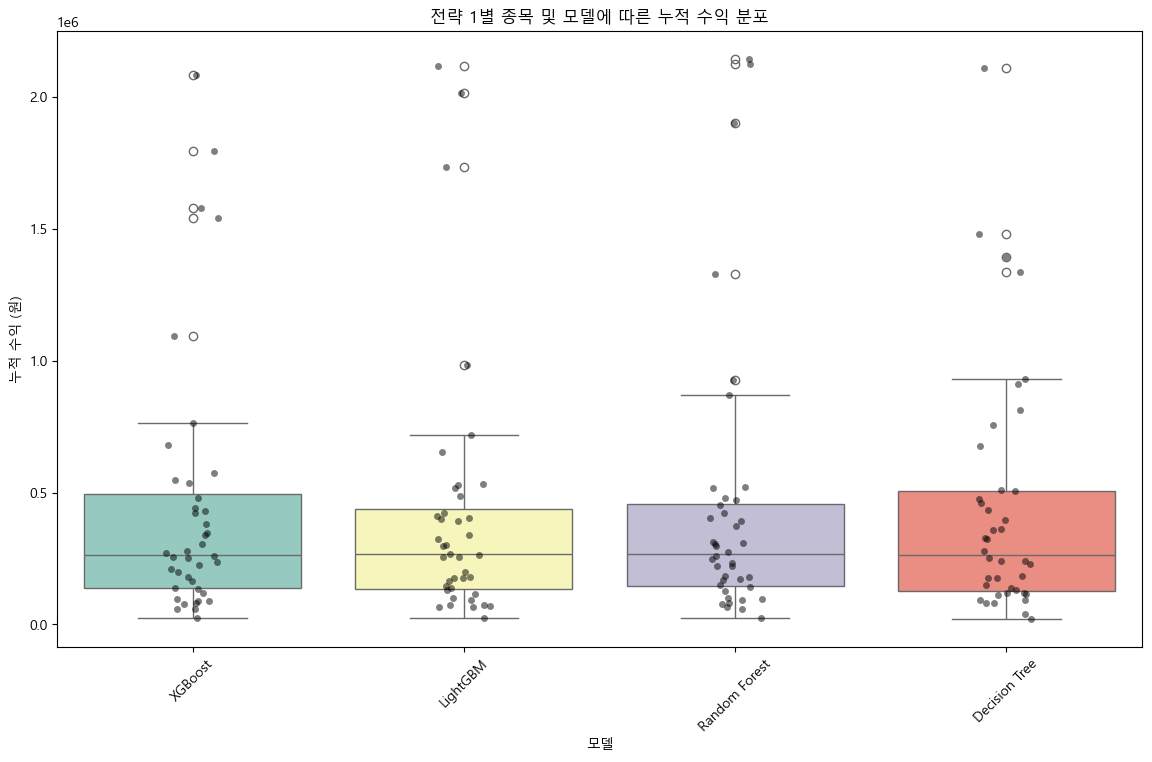


전략 1 결과:

   Ticker         Model  Total Profit   Total Loss  Payoff Ratio  Profit Factor     Win Rate  Total Trades  Max Holding Period   Max Profit     Max Loss
005930.KS       XGBoost  1.807467e+05 1.559200e+05      1.225469       1.159227   190.909091           110                  25  5911.944199  3259.368860
005930.KS      LightGBM  1.983655e+05 1.511848e+05      1.259356       1.312073   251.685393            89                  72  5383.675271  3259.368860
005930.KS Random Forest  1.682288e+05 1.373734e+05      1.218298       1.224610   195.959596            99                  23  5911.944199  3259.368860
005930.KS Decision Tree  1.845385e+05 1.553636e+05      1.278741       1.187785   209.433962           106                  29  5911.944199  3259.368860
005935.KS       XGBoost  7.637010e+04 6.504707e+04      1.135580       1.174074   102.521008           119                  13  2659.913250  2758.426640
005935.KS      LightGBM  6.432908e+04 5.338767e+04      1.180844       

C:\Users\jinju\AppData\Local\Temp\ipykernel_16200\4251019186.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='Total Profit', data=df_results, palette='Set3')


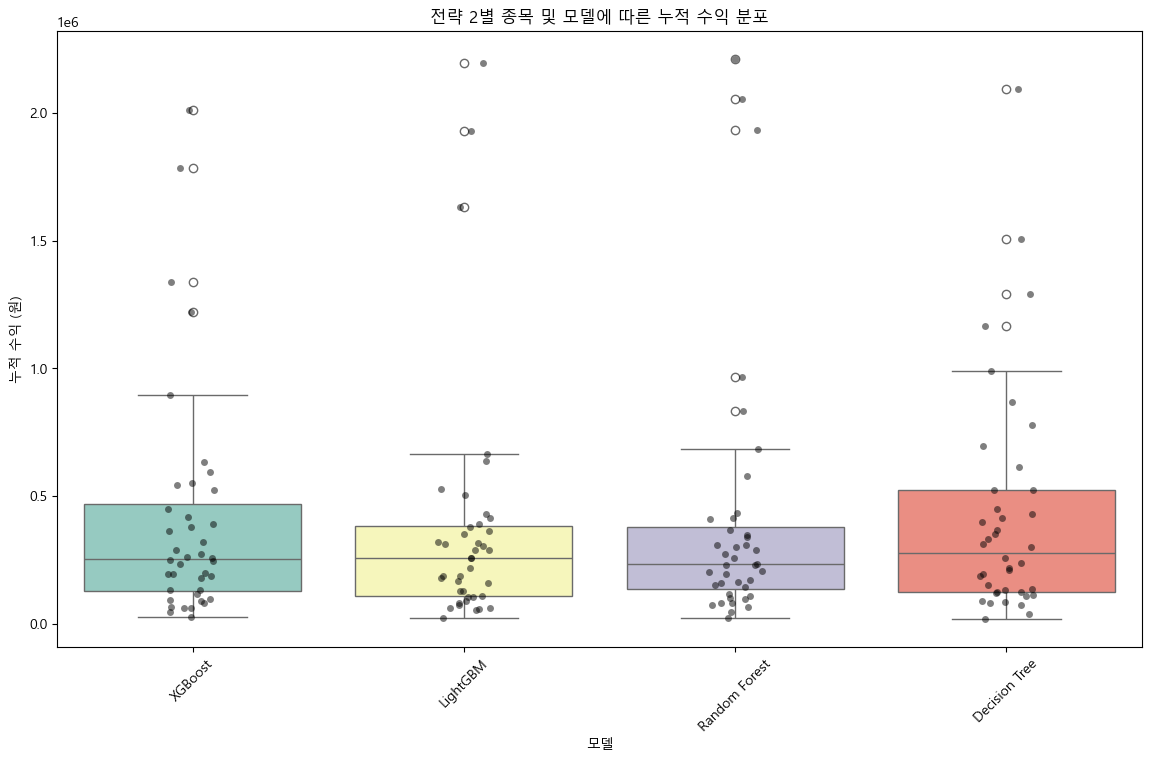


전략 2 결과:

   Ticker         Model  Total Profit   Total Loss  Payoff Ratio  Profit Factor     Win Rate  Total Trades  Max Holding Period   Max Profit     Max Loss
005930.KS       XGBoost  1.858605e+05 1.659297e+05      1.203473       1.120116   477.777778            45                  40  5911.944199  3259.368860
005930.KS      LightGBM  1.871319e+05 1.618252e+05      1.220925       1.156383   597.222222            36                  71  5383.675271  3259.368860
005930.KS Random Forest  1.614518e+05 1.433276e+05      1.239727       1.126453   436.585366            41                  30  5911.944199  3259.368860
005930.KS Decision Tree  1.854649e+05 1.766812e+05      1.273265       1.049715   440.816327            49                  40  5911.944199  3259.368860
005935.KS       XGBoost  6.248638e+04 7.136562e+04      0.983900       0.875581   220.454545            44                  19  2760.435454  2758.426640
005935.KS      LightGBM  5.460422e+04 4.851410e+04      1.239511       

C:\Users\jinju\AppData\Local\Temp\ipykernel_16200\4251019186.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='Total Profit', data=df_results, palette='Set3')


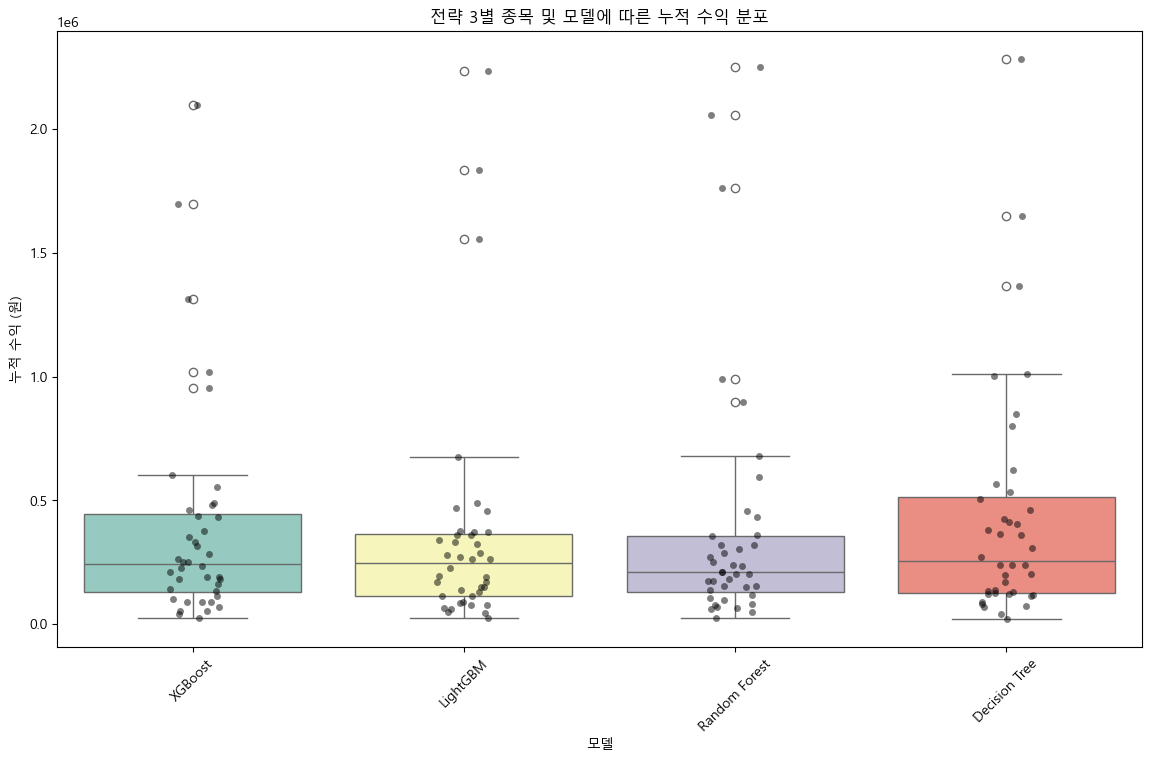


전략 3 결과:

   Ticker         Model  Total Profit   Total Loss  Payoff Ratio  Profit Factor     Win Rate  Total Trades  Max Holding Period   Max Profit     Max Loss
005930.KS       XGBoost  1.917690e+05 1.707489e+05      1.176819       1.123105  1210.526316            19                  67  5383.675271  3259.368860
005930.KS      LightGBM  1.945740e+05 1.716839e+05      1.214279       1.133327  1244.444444            18                 165  5911.944199  3259.368860
005930.KS Random Forest  1.758492e+05 1.479571e+05      1.218528       1.188515   761.538462            26                  73  5911.944199  3259.368860
005930.KS Decision Tree  2.037370e+05 1.790954e+05      1.264511       1.137589   896.296296            27                  62  5911.944199  3259.368860
005935.KS       XGBoost  5.298859e+04 6.238247e+04      1.061768       0.849415   380.952381            21                  34  2659.913250  2758.426640
005935.KS      LightGBM  4.671634e+04 4.227806e+04      1.075512       

C:\Users\jinju\AppData\Local\Temp\ipykernel_16200\4251019186.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='Total Profit', data=df_results, palette='Set3')


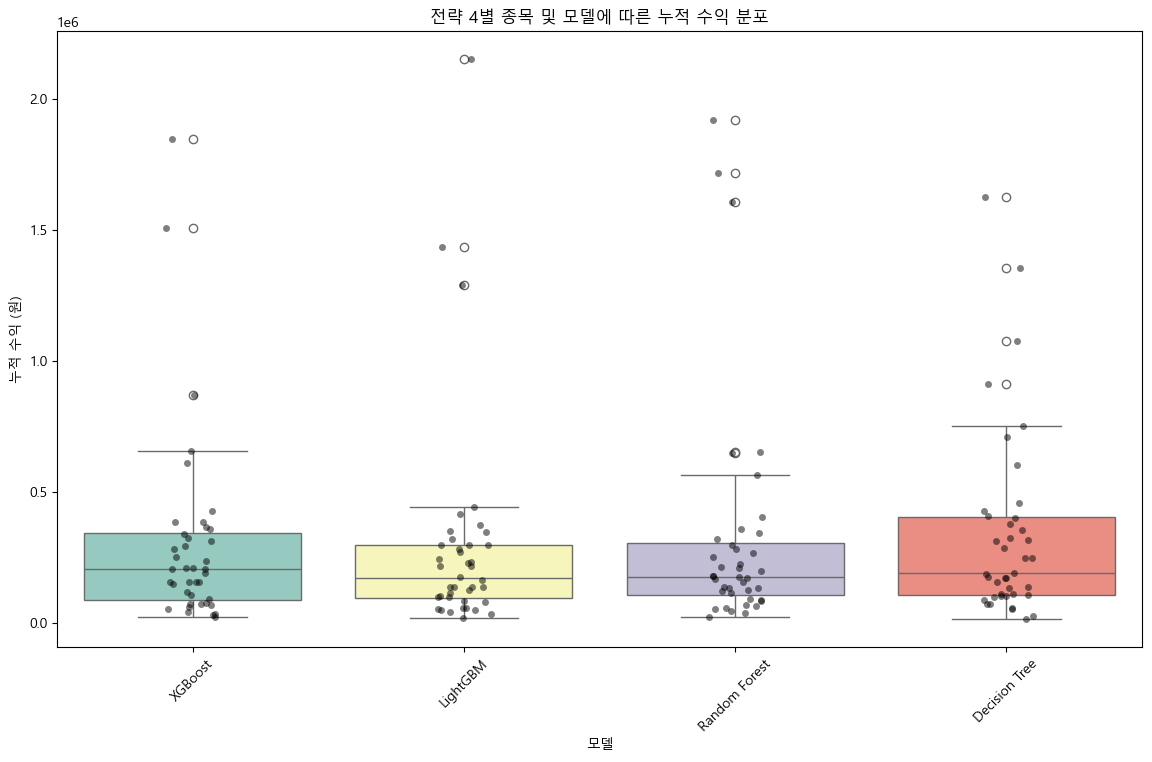


전략 4 결과:

   Ticker         Model  Total Profit   Total Loss  Payoff Ratio  Profit Factor     Win Rate  Total Trades  Max Holding Period   Max Profit     Max Loss
005930.KS       XGBoost  1.550857e+05 1.435374e+05      1.194503       1.080455   562.500000            32                  39  3048.229832  3259.368860
005930.KS      LightGBM  1.641448e+05 1.506000e+05      1.211043       1.089939   630.000000            30                  70  5383.675271  3259.368860
005930.KS Random Forest  1.366370e+05 1.206349e+05      1.205724       1.132649   469.696970            33                  29  5383.675271  3259.368860
005930.KS Decision Tree  1.568333e+05 1.493181e+05      1.261538       1.050330   427.906977            43                  39  5911.944199  3259.368860
005935.KS       XGBoost  3.063596e+04 4.745000e+04      0.909177       0.645647   213.043478            23                  18  2240.938314  2758.426640
005935.KS      LightGBM  3.391051e+04 2.771559e+04      1.271498       

C:\Users\jinju\AppData\Local\Temp\ipykernel_16200\4251019186.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='Total Profit', data=df_results, palette='Set3')


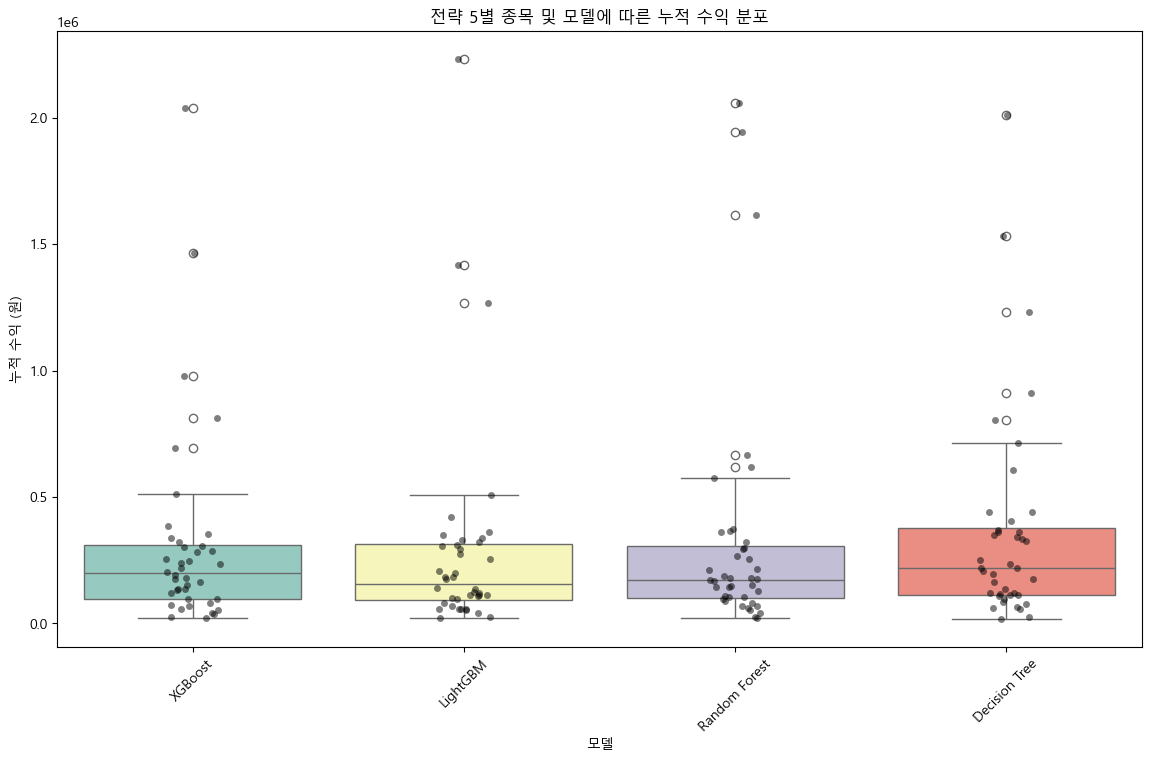


전략 5 결과:

   Ticker         Model  Total Profit   Total Loss  Payoff Ratio  Profit Factor     Win Rate  Total Trades  Max Holding Period   Max Profit     Max Loss
005930.KS       XGBoost  1.737236e+05 1.531622e+05      1.183800       1.134246  1287.500000            16                  66  5383.675271  3259.368860
005930.KS      LightGBM  1.843574e+05 1.569226e+05      1.202936       1.174830  1393.333333            15                 156  5911.944199  3259.368860
005930.KS Random Forest  1.515039e+05 1.267291e+05      1.195495       1.195495   786.363636            22                  72  5911.944199  3259.368860
005930.KS Decision Tree  1.768889e+05 1.570134e+05      1.338516       1.126584   918.181818            22                  56  5911.944199  3259.368860
005935.KS       XGBoost  2.553052e+04 3.955519e+04      0.865835       0.645440   512.500000             8                  33  2659.913250  2758.426640
005935.KS      LightGBM  2.552360e+04 2.152392e+04      1.185825       

C:\Users\jinju\AppData\Local\Temp\ipykernel_16200\4251019186.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='Total Profit', data=df_results, palette='Set3')


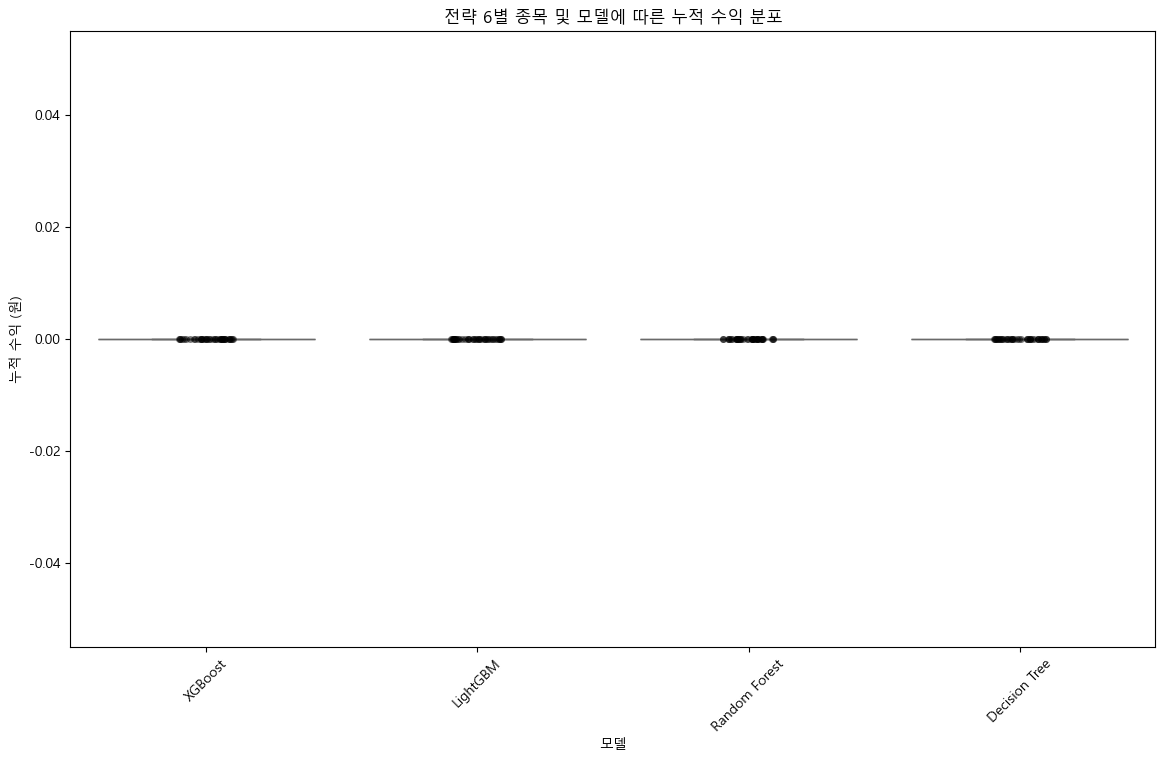


전략 6 결과:

   Ticker         Model  Total Profit  Total Loss  Payoff Ratio  Profit Factor  Win Rate  Total Trades  Max Holding Period  Max Profit  Max Loss
005930.KS       XGBoost             0           0           NaN            inf       inf             0                   0           0         0
005930.KS      LightGBM             0           0           NaN            inf       inf             0                   0           0         0
005930.KS Random Forest             0           0           NaN            inf       inf             0                   0           0         0
005930.KS Decision Tree             0           0           NaN            inf       inf             0                   0           0         0
005935.KS       XGBoost             0           0           NaN            inf       inf             0                   0           0         0
005935.KS      LightGBM             0           0           NaN            inf       inf             0                 

In [4]:
# 각 종목에 대해 모델 실행 및 결과 저장
for ticker in tickers:
    # 주식 데이터를 가져옴
    df = yf.Ticker(ticker).history(start='2009-01-01', end='2024-08-01', auto_adjust=False)
    
    # 타임존 제거
    df.index = df.index.tz_localize(None)

    # 필요한 기술적 지표들 추가
    df['RSI'] = ta.RSI(df['Adj Close'])
    df['Stochastic_Fast_K'], df['Stochastic_Fast_D'] = ta.STOCHF(df['High'], df['Low'], df['Adj Close'])
    df['Stochastic_Slow_K'], df['Stochastic_Slow_D'] = ta.STOCH(df['High'], df['Low'], df['Adj Close'])
    df['CCI'] = ta.CCI(df['High'], df['Low'], df['Adj Close'])
    df['OBV'] = ta.OBV(df['Adj Close'], df['Volume'])
    df['MFI'] = ta.MFI(df['High'], df['Low'], df['Adj Close'], df['Volume'])
    df['Aroon_Up'], df['Aroon_Down'] = ta.AROON(df['High'], df['Low'])
    df['Stochastic_RSI'] = ta.STOCHRSI(df['Adj Close'])[0]
    df['Ultimate_Oscillator'] = ta.ULTOSC(df['High'], df['Low'], df['Adj Close'])
    df['ADX'] = ta.ADX(df['High'], df['Low'], df['Adj Close'])
    df['ADXR'] = ta.ADXR(df['High'], df['Low'], df['Adj Close'])

    # 2010년 이후 데이터만 사용
    df = df[df.index >= '2010-01-01']

    # NaN이 포함되지 않은 데이터만 사용
    df = df.dropna()

    # 학습 데이터와 테스트 데이터로 분리
    train_data_final = df[(df.index >= '2010-01-01') & (df.index <= '2021-08-31')].copy()
    test_data = df[(df.index >= '2021-09-01') & (df.index <= '2024-07-31')].copy()

    # 'Act' 변수 추가 - 다음 거래일의 수정 종가가 전날 수정 종가보다 높은 경우 1, 낮은 경우 0
    train_data_final.loc[:, 'Act'] = np.where(train_data_final['Adj Close'].shift(-1) < train_data_final['Adj Close'], 1, 0)
    test_data.loc[:, 'Act'] = np.where(test_data['Adj Close'].shift(-1) < test_data['Adj Close'], 1, 0)

    # 입력 변수와 타겟 변수 설정
    X_train = train_data_final[['RSI', 'Stochastic_Fast_K', 'Stochastic_Fast_D', 'Stochastic_Slow_K', 'Stochastic_Slow_D', 
                                'CCI', 'OBV', 'MFI', 'Aroon_Up', 'Aroon_Down', 'Stochastic_RSI', 'Ultimate_Oscillator', 
                                'ADX', 'ADXR']]
    y_train = train_data_final['Act']

    X_test = test_data[['RSI', 'Stochastic_Fast_K', 'Stochastic_Fast_D', 'Stochastic_Slow_K', 'Stochastic_Slow_D', 
                        'CCI', 'OBV', 'MFI', 'Aroon_Up', 'Aroon_Down', 'Stochastic_RSI', 'Ultimate_Oscillator', 
                        'ADX', 'ADXR']]
    y_test = test_data['Act']

    optimized_models = {}

    # XGBoost 기본 모델 학습
    optimized_models["XGBoost"] = xgb.XGBClassifier()
    optimized_models["XGBoost"].fit(X_train, y_train)

    # LightGBM 기본 모델 학습
    optimized_models["LightGBM"] = lgb.LGBMClassifier()
    optimized_models["LightGBM"].fit(X_train, y_train)

    # Random Forest 기본 모델 학습
    optimized_models["Random Forest"] = RandomForestClassifier()
    optimized_models["Random Forest"].fit(X_train, y_train)

    # Decision Tree 기본 모델 학습
    optimized_models["Decision Tree"] = DecisionTreeClassifier()
    optimized_models["Decision Tree"].fit(X_train, y_train)

    # 각 전략별 결과 저장 (Naive Bayes와 Logistic Regression 제외)
    for name, model in optimized_models.items():
        # 테스트 데이터에 대한 예측 및 평가
        test_data['Pre'] = model.predict(X_test)

        # Pre와 Act 결과를 CSV로 저장
        pre_act_results = test_data[['Pre', 'Act']]
        pre_act_results.to_csv(f"{ticker}_{name}_pre_act_results.csv", index=False)

        for strategy_type in range(1, 7):  # 1 ~ 6번 전략 (6번이 Buy and Hold 전략)
            test_metrics = trading_strategy(test_data, strategy_type)
            results_test_all[strategy_type].append([
                ticker, 
                name, 
                test_metrics['Total Profit'], 
                test_metrics['Total Loss'], 
                test_metrics['Payoff Ratio'], 
                test_metrics['Profit Factor'], 
                test_metrics['Win Rate'], 
                test_metrics['Total Trades'],
                test_metrics['Max Holding Period'],
                test_metrics['Max Profit'],
                test_metrics['Max Loss'],
            ])

# 결과 저장 및 시각화 부분
for strategy_type in range(1, 7):
    df_results = pd.DataFrame(results_test_all[strategy_type], 
                              columns=['Ticker', 'Model', 'Total Profit', 'Total Loss', 
                                       'Payoff Ratio', 'Profit Factor', 'Win Rate', 'Total Trades', 
                                       'Max Holding Period', 'Max Profit', 'Max Loss',])

    # 결과 CSV로 저장
    df_results.to_csv(f"strategy_{strategy_type}_results.csv", index=False)

    # 시각화 및 결과 출력 (기존 코드 유지)
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Model', y='Total Profit', data=df_results, palette='Set3')
    sns.stripplot(x='Model', y='Total Profit', data=df_results, dodge=True, jitter=True, alpha=0.5, color='black', marker='o')
    
    plt.title(f'전략 {strategy_type}별 종목 및 모델에 따른 누적 수익 분포')
    plt.xlabel('모델')
    plt.ylabel('누적 수익 (원)')
    plt.xticks(rotation=45)
    plt.show()

    # 결과 표 출력
    print(f"\n전략 {strategy_type} 결과:\n")
    print(df_results.to_string(index=False))